In [25]:
import os
import pickle
import torch
import numpy as np
import scipy.sparse as sp
import dgl

from utils import select_source, compute_rank_error, compute_hit_ratio

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [26]:
SEED = 42
EPOCHS = 100
TEST_RATIO = 0.3  # ratio for splitting the test set
DEVICE = "cpu"

In [27]:
with open(os.path.join("facebook", "combined-adj-sparsefeat.pkl"), "rb") as f:
    friendship_matrix, feature_matrix = pickle.load(f, encoding='latin1')

print(f"Friendship matrix shape : {friendship_matrix.shape}")
print(f"Feature matrix shape    : {feature_matrix.shape}")

src, dst = np.nonzero(friendship_matrix)
g = dgl.graph((src, dst))
g.ndata['feat'] = torch.tensor(feature_matrix.todense(), dtype=torch.float32)
g

Friendship matrix shape : (4039, 4039)
Feature matrix shape    : (4039, 1283)


Graph(num_nodes=4039, num_edges=176468,
      ndata_schemes={'feat': Scheme(shape=(1283,), dtype=torch.float32)}
      edata_schemes={})

In [28]:
def split_dataset(g):

    u, v = g.edges()

    eids = np.arange(g.number_of_edges())
    np.random.seed( SEED )
    eids = np.random.permutation(eids)
    test_size = int(len(eids) * TEST_RATIO)  # number of edges in test set

    # get positive edges for test and train
    test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
    train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

    # Find all negative edges
    adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
    adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
    neg_u, neg_v = np.where(adj_neg != 0)

    # split the negative edges for training and testing
    np.random.seed( SEED )
    neg_eids = np.random.choice(len(neg_u), g.number_of_edges())
    test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
    train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]

    # construct positive and negative graphs for training and testing
    train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
    train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

    test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
    test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

    # training graph
    train_g = dgl.remove_edges(g, eids[:test_size])
    train_g = dgl.add_self_loop(train_g)

    return {
        "train_pos_g": train_pos_g,
        "train_neg_g": train_neg_g,
        "test_pos_g":  test_pos_g,
        "test_neg_g":  test_neg_g,
        "train_g":     train_g
    }

In [29]:
from model import Pipeline

#pipeline = Pipeline("GCN", 16, feature_matrix.shape[1])
pipeline = Pipeline("SAGE", 16, feature_matrix.shape[1])
ds = split_dataset(g)
train_losses = pipeline.train(ds)

100%|██████████| 100/100 [00:02<00:00, 43.45it/s]


AUC: 0.929908


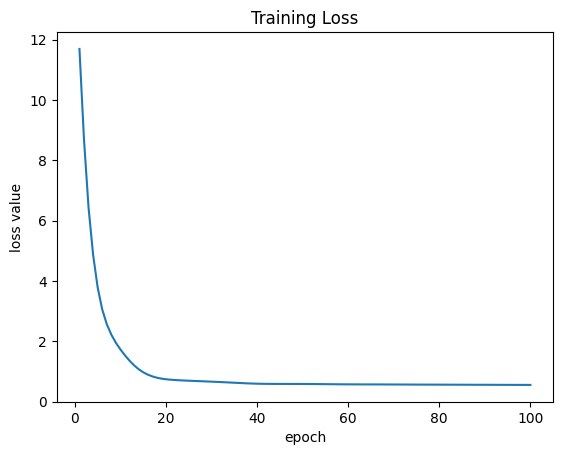

In [30]:
import matplotlib.pyplot as plt

plt.title("Training Loss")
plt.plot(range(1, EPOCHS+1), train_losses)
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.show()

In [31]:
recommend_list = pipeline.recommend(g, 0)
print(recommend_list[:10])

[(426, 2.60609769821167), (399, 2.517890691757202), (369, 2.479832649230957), (498, 2.438979387283325), (483, 2.4242234230041504), (371, 2.423776388168335), (451, 2.42232608795166), (470, 2.4064526557922363), (349, 2.4036455154418945), (413, 2.400721311569214)]


In [32]:
MAX_CHANGES = 20
NUM_PAIRS = 30

FRIEND_SELECT_METHOD = "rank"
RANK_TOP = 10

In [33]:
import random

pairs = []
start = 50
end = 100

for _ in range(NUM_PAIRS):
    tgt = random.randint(0, friendship_matrix.shape[0]-1)
    recommend_list = pipeline.recommend(g, tgt)
    src = select_source(recommend_list, start, end)
    pairs.append((src, tgt))

pairs[:5]

[(1994, 2145), (1661, 978), (117, 9), (364, 548), (412, 3693)]

In [34]:
def get_target_friends(friendship_matrix, feature_matrix, target):
    users = []
    friends = friendship_matrix.toarray()
    features = feature_matrix.toarray()

    for u, is_friend in enumerate(friends[target]):
        if is_friend:
            users.append(u)
    users = np.array(users)
    all_users_list = users.tolist()
    all_users_features = features[all_users_list, :]

    combined_features = np.sum(all_users_features, axis=0)

    top_10_indices = np.argsort(combined_features)[-MAX_CHANGES:][::-1]
    top_10_values = combined_features[top_10_indices]

    return top_10_indices, top_10_values, all_users_features

def get_target_rank_friends(friendship_matrix, feature_matrix, ranklist):
    features = feature_matrix.toarray()
    all_users_list = [ user for user, _ in ranklist[:RANK_TOP] ]
    all_users_features = features[all_users_list, :]

    combined_features = np.sum(all_users_features, axis=0)

    top_10_indices = np.argsort(combined_features)[-MAX_CHANGES:][::-1]
    top_10_values = combined_features[top_10_indices]

    return top_10_indices, top_10_values, all_users_features

def method_1(friendship_matrix, feature_matrix, pair, ranklist):
    user_id, tgt = pair
    if FRIEND_SELECT_METHOD == "rank":
        top_10_indices, top_10_values , c = get_target_rank_friends(friendship_matrix, feature_matrix, ranklist)
    else:
        top_10_indices, top_10_values , c = get_target_friends(friendship_matrix, feature_matrix, tgt)
    src, dst = np.nonzero(friendship_matrix)
    g_change = dgl.graph((src, dst))
    modified_features = feature_matrix.toarray().copy()
    modified_features[user_id, top_10_indices] = 1
    g_change.ndata['feat'] = torch.tensor(modified_features, dtype=torch.float32)
    return g_change

In [35]:
from tqdm.auto import tqdm

origin_ranks, new_ranks = [], []

for pair in tqdm(pairs):
    g_change = method_1(friendship_matrix, feature_matrix, pair, pipeline.recommend(g, pair[1]))

    origin_rank = pipeline.predict_rank(g, pair[0], pair[1])

    ds = split_dataset(g_change)
    new_pipeline = Pipeline("GCN", 16, feature_matrix.shape[1])
    train_losses = new_pipeline.train(ds)

    #new_rank = pipeline.predict_rank(g_change, pair[0], pair[1])
    new_rank = new_pipeline.predict_rank(g_change, pair[0], pair[1])

    origin_ranks.append(origin_rank)
    new_ranks.append(new_rank)

print( compute_rank_error(origin_ranks, new_ranks) )    

100%|██████████| 100/100 [00:02<00:00, 46.93it/s]



AUC: 0.968136


100%|██████████| 100/100 [00:01<00:00, 51.46it/s]



AUC: 0.967426


100%|██████████| 100/100 [00:02<00:00, 48.08it/s]



AUC: 0.966911


100%|██████████| 100/100 [00:19<00:00,  5.21it/s]



AUC: 0.966503


100%|██████████| 100/100 [00:19<00:00,  5.15it/s]



AUC: 0.965645


100%|██████████| 100/100 [00:20<00:00,  4.94it/s]



AUC: 0.966891


100%|██████████| 100/100 [00:14<00:00,  6.85it/s]



AUC: 0.968073


100%|██████████| 100/100 [00:01<00:00, 59.26it/s]



AUC: 0.967149


100%|██████████| 100/100 [00:02<00:00, 47.94it/s]



AUC: 0.964187


100%|██████████| 100/100 [00:02<00:00, 48.71it/s]



AUC: 0.966432


100%|██████████| 100/100 [00:19<00:00,  5.09it/s]



AUC: 0.964731


100%|██████████| 100/100 [00:17<00:00,  5.66it/s]



AUC: 0.967959


100%|██████████| 100/100 [00:17<00:00,  5.60it/s]



AUC: 0.965868


100%|██████████| 100/100 [00:07<00:00, 12.62it/s]



AUC: 0.968012


100%|██████████| 100/100 [00:01<00:00, 57.92it/s]



AUC: 0.964965


100%|██████████| 100/100 [00:03<00:00, 26.32it/s]



AUC: 0.967346


100%|██████████| 100/100 [00:17<00:00,  5.74it/s]



AUC: 0.964080


100%|██████████| 100/100 [00:17<00:00,  5.78it/s]



AUC: 0.968263


100%|██████████| 100/100 [00:17<00:00,  5.71it/s]



AUC: 0.961577


100%|██████████| 100/100 [00:17<00:00,  5.85it/s]



AUC: 0.967012


100%|██████████| 100/100 [00:17<00:00,  5.79it/s]



AUC: 0.965037


100%|██████████| 100/100 [00:06<00:00, 14.61it/s]



AUC: 0.968701


100%|██████████| 100/100 [00:01<00:00, 60.13it/s]



AUC: 0.968018


100%|██████████| 100/100 [00:01<00:00, 60.66it/s]



AUC: 0.967392


100%|██████████| 100/100 [00:01<00:00, 60.51it/s]



AUC: 0.968673


100%|██████████| 100/100 [00:01<00:00, 59.99it/s]



AUC: 0.959271


100%|██████████| 100/100 [00:01<00:00, 59.35it/s]



AUC: 0.961762


100%|██████████| 100/100 [00:01<00:00, 58.91it/s]



AUC: 0.966643


100%|██████████| 100/100 [00:01<00:00, 58.89it/s]



AUC: 0.967298


100%|██████████| 100/100 [00:01<00:00, 60.20it/s]



AUC: 0.968338


100%|██████████| 30/30 [07:45<00:00, 15.52s/it]

{'average': 47.25, 'max': 55, 'min': 35}


In [36]:
print(origin_ranks)
print(new_ranks)

[76, 69, 56, 90, 74, 82, 82, 84, 85, 99, 97, 50, 51, 89, 75, 56, 98, 68, 62, 84, 69, 97, 66, 97, 88, 99, 51, 90, 94, 96]
[470, 539, 153, 35, 2854, 428, 3658, 520, 577, 159, 502, 588, 518, 596, 25, 275, 148, 1698, 504, 439, 444, 292, 511, 182, 53, 464, 213, 750, 45, 611]
